In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yaml
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, brier_score_loss
from sklearn.calibration import calibration_curve
from itertools import combinations

In [2]:
from molpipeline.pipeline import Pipeline
from molpipeline.pipeline_elements.any2mol import SmilesToMolPipelineElement
from molpipeline.pipeline_elements.mol2any import MolToFoldedMorganFingerprint
from molpipeline.sklearn_estimators.similarity_transformation import TanimotoToTraining

In [3]:
with open("../config/endpoints.yaml", "r", encoding="UTF-8") as infile:
    endpoint_list = yaml.safe_load(infile)["endpoint"]

In [4]:
repo_base_path = Path(".").resolve().parents[0]

In [5]:
processed_endpoint_list = []
to_finish = 0
prediction_folder = repo_base_path / "data" / "intermediate_data" / "model_predictions"
for endpoint in endpoint_list:
    nnfp_endpoint_result_file = prediction_folder / f"neural_fingerprint_predictions_{endpoint}.tsv.gz"
    morgan_endpoint_result_file = prediction_folder / f"morgan_fingerprint_predictions_{endpoint}.tsv.gz"
    if nnfp_endpoint_result_file.exists() and morgan_endpoint_result_file.exists():
        processed_endpoint_list.append(endpoint)
    else:
        to_finish += 1
for i, endpoint in enumerate(processed_endpoint_list):
    print(i, endpoint)
print(f"Left to finish: {to_finish}")

0 APR_HepG2_CellLoss_72h_dn
1 ATG_NRF2_ARE_CIS_up
2 ATG_PXRE_CIS_up
3 BSK_3C_HLADR_down
4 BSK_3C_Proliferation_down
5 BSK_3C_SRB_down
6 BSK_3C_Vis_down
7 BSK_4H_Eotaxin3_down
8 BSK_CASM3C_Proliferation_down
9 BSK_LPS_VCAM1_down
10 BSK_SAg_CD38_down
11 BSK_SAg_CD40_down
12 BSK_SAg_Proliferation_down
Left to finish: 6


In [6]:
analyzed_endpoint = processed_endpoint_list[3]
print(analyzed_endpoint)

BSK_3C_HLADR_down


In [7]:
endpoint_neural_prediction_df = pd.read_csv(
    prediction_folder / f"neural_fingerprint_predictions_{analyzed_endpoint}.tsv.gz",
    sep="\t"
)
endpoint_neural_prediction_df["encoding"] = "Neural FP"

(60.1, 145.9)

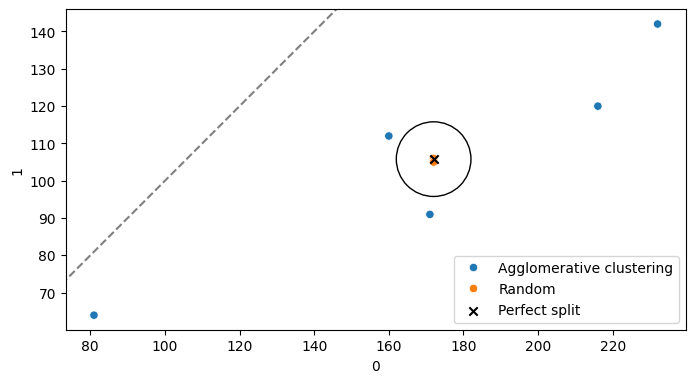

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
count_df = endpoint_neural_prediction_df.pivot_table(index=["trial", "Split strategy"], values="smiles", columns="label", aggfunc="nunique")
count_df.reset_index(inplace=True)
pos_total, neg_total = count_df.query("`Split strategy` == 'Random'")[[1,0]].sum(axis=0)
n_trials = endpoint_neural_prediction_df.trial.nunique()
sns.scatterplot(data=count_df, x=0, y=1, hue="Split strategy", ax=ax)
ax.scatter([neg_total/n_trials], [pos_total/n_trials], label="Perfect split", marker="x", color="k")
Drawing_uncolored_circle = plt.Circle(
    [neg_total/n_trials, pos_total/n_trials],
      10 ,
      fill = False
)
 
ax.set_aspect(1)
ax.add_artist( Drawing_uncolored_circle )
ax.legend()

x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

ax.plot([0,5000],[0,5000], color="grey", ls="--")
ax.set_xlim(x_lim)

ax.set_ylim(y_lim)

In [9]:
def get_sim_pipeline() -> Pipeline:
    sim_pipeline = Pipeline(
        [
            ("smi2mol", SmilesToMolPipelineElement()),
            ("mol2morgan", MolToFoldedMorganFingerprint()),
            ("sim", TanimotoToTraining()),
        ]
    )
    return sim_pipeline
sim_dict = {}
for (model, split_strategy), iter_df in endpoint_neural_prediction_df.groupby(["model", "Split strategy"]):
    if model != "Chemprop":
        continue
    sim_list = []
    for trial in iter_df.trial.unique():
        training_smis = iter_df.loc[iter_df.trial != trial, "smiles"].tolist()
        test_smis = iter_df.loc[iter_df.trial == trial, "smiles"].tolist()
        sim_pl = get_sim_pipeline()
        sim_pl.fit(training_smis)
        max_sim = sim_pl.transform(test_smis).max(axis=1)
        if len(max_sim) != len(test_smis):
            raise AssertionError()
        sim_list.extend(max_sim.tolist())
    sim_dict[split_strategy] = sim_list


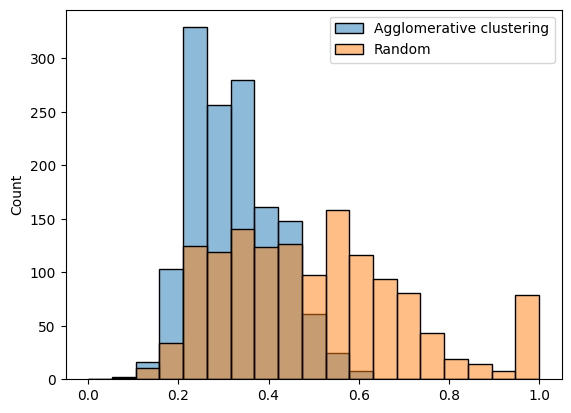

In [10]:
fig, ax = plt.subplots()
for split, sim_list in sim_dict.items():
    sns.histplot(sim_list, ax=ax, label=split, bins=np.linspace(0,1,20), alpha=0.5)
    
ax.legend()

In [11]:
endpoint_morgan_prediction_df = pd.read_csv(
    prediction_folder / f"morgan_fingerprint_predictions_{analyzed_endpoint}.tsv.gz",
    sep="\t",
)
endpoint_morgan_prediction_df["encoding"] = "Morgan FP"

In [12]:
for (endpoint, model, split_method, trial), iter_df in endpoint_neural_prediction_df.groupby(["endpoint", "model", "Split strategy", "trial"]):
    smiles_set = set(iter_df["smiles"].tolist())
    morgan_iter_df = endpoint_morgan_prediction_df.query("endpoint==@endpoint & model==@model & `Split strategy`==@split_method & trial==@trial")
    morang_smiles_set = set(morgan_iter_df["smiles"].tolist())
    if smiles_set != morang_smiles_set:
        if model == "Chemprop":
            print(endpoint, model, split_method, trial)
        else:
            raise ValueError(endpoint, model, split_method, trial)

BSK_3C_HLADR_down Chemprop Agglomerative clustering 0
BSK_3C_HLADR_down Chemprop Agglomerative clustering 1
BSK_3C_HLADR_down Chemprop Agglomerative clustering 2
BSK_3C_HLADR_down Chemprop Agglomerative clustering 3
BSK_3C_HLADR_down Chemprop Agglomerative clustering 4
BSK_3C_HLADR_down Chemprop Random 0
BSK_3C_HLADR_down Chemprop Random 1
BSK_3C_HLADR_down Chemprop Random 2
BSK_3C_HLADR_down Chemprop Random 3
BSK_3C_HLADR_down Chemprop Random 4


In [13]:
endpoint_prediction_df = pd.concat([endpoint_neural_prediction_df, endpoint_morgan_prediction_df])

In [14]:
endpoint_prediction_df["Model name"] = endpoint_prediction_df[["encoding", "model"]].apply(" + ".join, axis=1)

In [15]:
endpoint_prediction_df.loc[endpoint_prediction_df["model"] == "Chemprop", "Model name"] = "Chemprop"

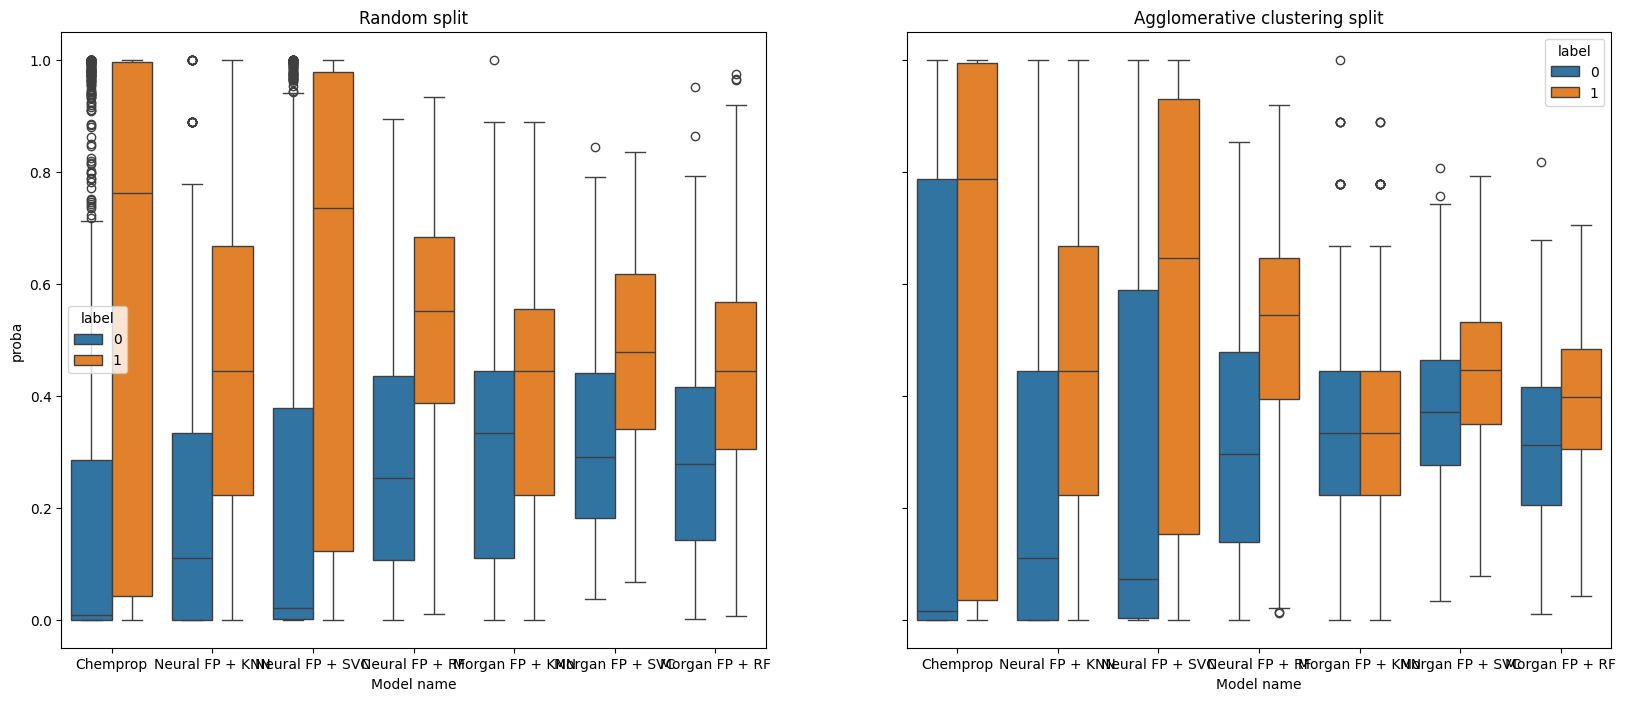

In [16]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2, sharey=True)
sns.boxplot(data=endpoint_prediction_df.query("`Split strategy` == 'Random'"), x="Model name", hue="label", y="proba", ax=axs[0])
sns.boxplot(data=endpoint_prediction_df.query("`Split strategy` == 'Agglomerative clustering'"), x="Model name", hue="label", y="proba", ax=axs[1])
axs[0].set_title("Random split")
axs[1].set_title("Agglomerative clustering split");

In [17]:
performance_df = []
for (model, trial, split), iter_df in endpoint_prediction_df.groupby(["Model name", "trial", "Split strategy"]):
    iter_dict = {
        "model": model,
        "trial": trial,
        "split": split,
    }
    ba_dict = {"metric": "BA", "Performance": balanced_accuracy_score(iter_df["label"], iter_df["prediction"])}
    brier_dict = {"metric": "Brier score", "Performance": brier_score_loss(iter_df["label"], iter_df["proba"])}
    for perf_dict in [ba_dict, brier_dict]:
        perf_dict.update(iter_dict)
        performance_df.append(perf_dict)
performance_df = pd.DataFrame(performance_df)

In [18]:
model_order = [
    'Morgan FP + KNN',
    'Neural FP + KNN',
    'Morgan FP + RF',
    'Neural FP + RF',
    'Morgan FP + SVC',
    'Neural FP + SVC',
    "Chemprop",
]
model_color = {m: c for m, c in zip(model_order, sns.color_palette("Paired"))}

/tmp/ipykernel_56563/2485111919.py:2: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.boxplot(data=performance_df.query("split == 'Random'"), x="metric", hue="model", y="Performance", ax=axs[0], palette=sns.color_palette("Paired"), hue_order=model_order)
/tmp/ipykernel_56563/2485111919.py:3: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  sns.boxplot(data=performance_df.query("split == 'Agglomerative clustering'"), x="metric", hue="model", y="Performance", ax=axs[1], palette=sns.color_palette("Paired"), hue_order=model_order)


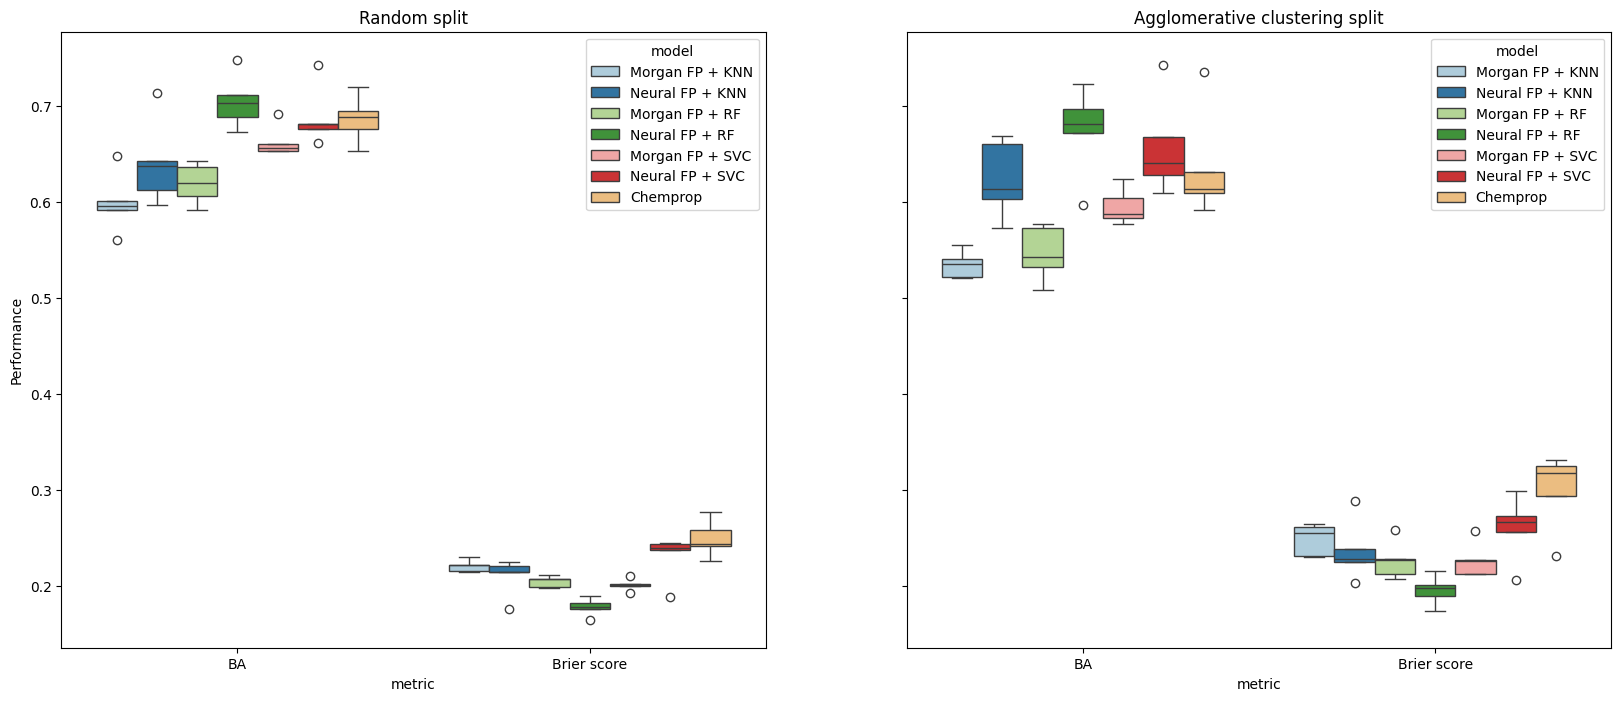

In [19]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2, sharey=True)
sns.boxplot(data=performance_df.query("split == 'Random'"), x="metric", hue="model", y="Performance", ax=axs[0], palette=sns.color_palette("Paired"), hue_order=model_order)
sns.boxplot(data=performance_df.query("split == 'Agglomerative clustering'"), x="metric", hue="model", y="Performance", ax=axs[1], palette=sns.color_palette("Paired"), hue_order=model_order)
axs[0].set_title("Random split")
axs[1].set_title("Agglomerative clustering split");

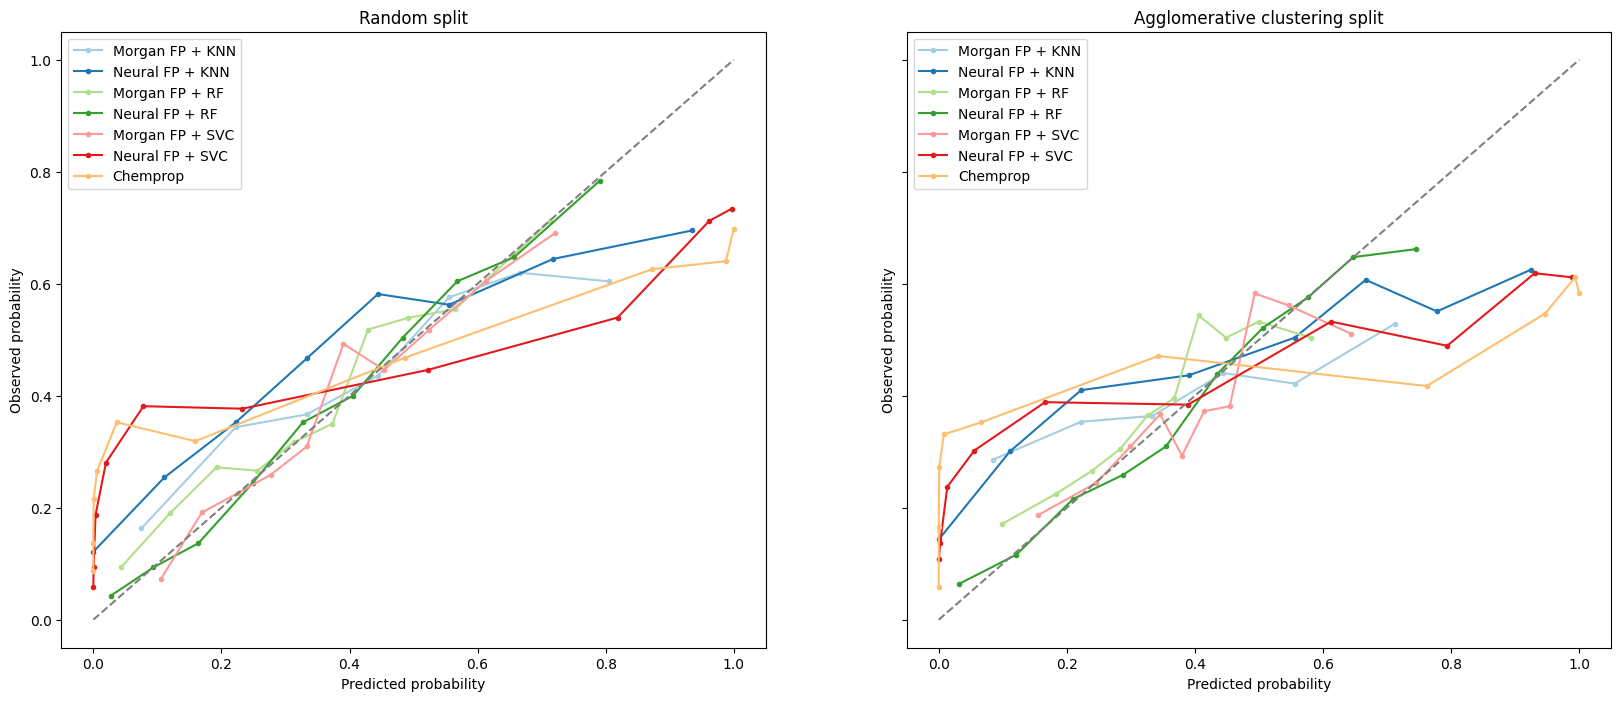

In [20]:
fig, axs = plt.subplots(figsize=(20,8), ncols=2, sharey=True)
name2ax_dict = {"Random": 0, "Agglomerative clustering": 1}
for model, color in model_color.items():
    for split in endpoint_prediction_df["Split strategy"].unique():
        iter_df = endpoint_prediction_df.query("`Model name`==@model & `Split strategy` == @split")
        prob_true, prob_pred = calibration_curve(iter_df["label"], iter_df["proba"], n_bins=10, strategy="quantile")
        bs = brier_score_loss(iter_df["label"], iter_df["proba"])
        ax = axs[name2ax_dict[split]]
        ax.plot(prob_pred, prob_true, label=f"{model}", marker=".", color=color)
axs[0].plot((0,1), (0,1), ls="--", color="gray")
axs[1].plot((0,1), (0,1), ls="--", color="gray")
axs[0].legend()
axs[1].legend()
axs[0].set_xlabel("Predicted probability")
axs[1].set_xlabel("Predicted probability")
axs[0].set_ylabel("Observed probability")
axs[1].set_ylabel("Observed probability")
axs[0].set_title("Random split")
axs[1].set_title("Agglomerative clustering split");